In [1]:
# Model 4 - Recursive Coefficient Estimation

In [2]:
#Importing the Excel file into Python

import pandas as pd
import numpy as np
import statsmodels.api as sm

# Replace 'your_file.csv' with the path to your actual CSV file
data = pd.read_excel("G:/My Drive/Ireland - Jasleen/Trinity/Coursework/Dissertation/Drafts/Analysis and Findings/Country Wise Analysis/NIFTY MidCap100 CleanData.xlsx")

# Check for missing values and remove rows with missing returns
data = data.dropna(subset=['Return'])

# Display the first few rows of the dataframe
print(data.head(20))

         Date  Unnamed: 1 Day of the week   PX_LAST    Return  \
0  2016-04-25        1998          Monday  13167.25 -0.595161   
1  2016-04-26        1997         Tuesday  13278.00  0.837584   
2  2016-04-27        1996       Wednesday  13305.55  0.207271   
3  2016-04-28        1995        Thursday  13163.45 -1.073719   
4  2016-04-29        1994          Friday  13195.30  0.241666   
5  2016-05-02        1993          Monday  13271.30  0.574310   
6  2016-05-03        1992         Tuesday  13156.05 -0.872208   
7  2016-05-04        1991       Wednesday  12964.30 -1.468230   
8  2016-05-05        1990        Thursday  12965.45  0.008870   
9  2016-05-06        1989          Friday  13001.85  0.280353   
10 2016-05-09        1988          Monday  13144.95  1.094600   
11 2016-05-10        1987         Tuesday  13108.65 -0.276534   
12 2016-05-11        1986       Wednesday  13095.90 -0.097311   
13 2016-05-12        1985        Thursday  13181.90  0.654547   
14 2016-05-13        1984

In [3]:
# Defining data range
# Specify the start and end dates of the desired range
start_date = '2016-05-02'
end_date = '2024-05-10'

# Filter the dataframe based on the date range
data = data.loc[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

# Print the selected columns
print(data)

           Date  Unnamed: 1 Day of the week   PX_LAST    Return  \
5    2016-05-02        1993          Monday  13271.30  0.574310   
6    2016-05-03        1992         Tuesday  13156.05 -0.872208   
7    2016-05-04        1991       Wednesday  12964.30 -1.468230   
8    2016-05-05        1990        Thursday  12965.45  0.008870   
9    2016-05-06        1989          Friday  13001.85  0.280353   
...         ...         ...             ...       ...       ...   
1590 2024-05-06           8          Monday  50662.20 -0.537318   
1591 2024-05-07           7         Tuesday  49674.45 -1.968935   
1592 2024-05-08           6       Wednesday  50036.30  0.725803   
1593 2024-05-09           5        Thursday  49109.15 -1.870337   
1594 2024-05-10           4          Friday  49532.30  0.857961   

                       Week Day of Week  
5     2016-05-02/2016-05-08      Monday  
6     2016-05-02/2016-05-08     Tuesday  
7     2016-05-02/2016-05-08   Wednesday  
8     2016-05-02/2016-05-08

In [4]:
# Drop rows with NaT in the 'Date' column
data = data.dropna(subset=['Date'])

# Extract the day of the week from the 'Date' column
data['Day_of_Week'] = data['Date'].dt.day_name()

# Perform one-hot encoding to create dummy variables for each day of the week
data_with_dummies = pd.get_dummies(data, columns=['Day_of_Week'], drop_first=False)

# Check if any of the columns contain boolean values and convert them to integer (0 and 1)
for col in data_with_dummies.columns:
    if data_with_dummies[col].dtype == 'bool':
        data_with_dummies[col] = data_with_dummies[col].astype(int)


# Display the resulting dataframe
data_with_dummies.head()

# import statsmodels.api as sm

# Define the independent variables (dummy variables for days of the week)
X_1 = data_with_dummies[['Day_of_Week_Monday', 
                       'Day_of_Week_Thursday', 'Day_of_Week_Tuesday', 
                       'Day_of_Week_Wednesday','Day_of_Week_Friday']]

# Define the dependent variable (Returns)
Y_1 = data_with_dummies['Return']

In [5]:
data_with_dummies.columns

data_with_dummies['Date'] = pd.to_datetime(data_with_dummies['Date'])
data_with_dummies.set_index('Date', inplace=True)

In [6]:
# Recursive Regression Formula

import statsmodels.formula.api as smf
def recursive_reg(variable, i, interval):
    # formula = 'Return ~ Day_of_Week_Monday + Day_of_Week_Thursday + Day_of_Week_Tuesday + Day_of_Week_Wednesday + Day_of_Week_Friday'
    formula = 'Return ~ Day_of_Week_Monday'
    results = smf.ols(formula, data_with_dummies.iloc[:i+interval]).fit()
    coeff=results.params[variable]
    se=results.bse[variable]

    return coeff, se

In [7]:
# Generate SE and Coefficients for each day of the week

parameters = [] 
for i in range (0, len(data_with_dummies)-5):
    coeff, se = recursive_reg('Day_of_Week_Monday', i, 5)
    parameters.append((coeff, se))

parameters=pd.DataFrame(parameters, columns=['coeff', 'se']\
                        , index=data_with_dummies.index[5:])
parameters['Day_of_Week_Monday + 2*se'] = parameters['coeff'] + 2*parameters['se']
parameters['Day_of_Week_Monday - 2*se'] = parameters['coeff'] - 2*parameters['se']

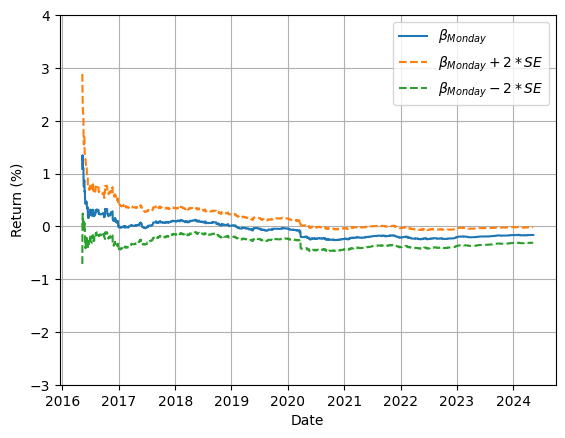

In [8]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(parameters['coeff'], label=r'$\beta_{Monday}$')
plt.plot(parameters['Day_of_Week_Monday + 2*se'], label=r'$\beta_{Monday} + 2*SE$', linestyle='dashed')
plt.plot(parameters['Day_of_Week_Monday - 2*se'], label=r'$\beta_{Monday} - 2*SE$', linestyle='dashed')
plt.ylim(-3, 4)
plt.xlabel('Date')
plt.ylabel('Return (%)')
plt.grid(True)
plt.legend()
plt.show()